# Introduction

The aim of our project is to find out whether the product created from two designated molecules is stable. Indeed, our vision is to ask a user to draw two molecules of his choice. Via the "reaction_utils" template, a product is created. To find out whether it was stable and whether the reaction was spontaneous, we also chose to calculate free enthalpies.

Free enthalpy, or Gibbs free energy, ΔG is a thermodynamic function that determines whether a chemical reaction can occur spontaneously at constant temperature and pressure. It is calculated by the formula ΔG=ΔH-TΔS where H is enthalpy [J], T is the temperature [K] and S is the entropy [J/K]. A reaction is spontaneous if the variation in free enthalpy is negative. In our case,  If the enthalpy of the sum of the reactants is greater than that of the product, then the latter is stable. This concept is therefore essential for predicting chemical equilibrium and optimizing the conditions of chemical reactions, whether industrial or biological. Free enthalpy thus enables us to better understand the direction and feasibility of chemical transformations.


# Materials and Methods

To reach our goal, which is to determine if the reaction of two given reactive is spontaneous or not at 0K, the problem was devided in multiple steps:
1. First, a drawing interface was created to enable the users to draw their reactants.
2. Then, the reactants were analyzed to determine what possible product they could yield using reaction templates. 
3. Finally, the energy of all molecules both reactants and product were calculated and compaired to conclude on the spontaneous character of the reaction at 0K.

All this steps can be summaryze with this chart : 

Molecule ( Smiles “CCOC…”) → Convert into 3D (xyz) → Calculate energy → Compare energies

## 1. Creating a drawing interface

First, a drawing interface inspired by the materials provided in lecture 12 was created using streamlit and ketcher. The interface was designed for the user to draw the two reagents,enableling them to see their drawing as well as the corresponding smiles, 3D visualization and energy of the molecules. Also, after chosen the type of wanted reaction, the product was generated using a reaction template. To apply the same feature display functions as for the reactants, several format conversions were required, which made this step particularly challenging. Finally, we made sure that the reaction total energy was shown, and that if the reaction was favourable, we could see it.

One of the main functions of this part was therefore to get the three functionalities of the drawn reagents. 'draw_and_process' indeed makes the link between the interface and the created functions : 
1. the user draws a molecule using the interface ketcher
2. the SMILES is displayed
3. the 3D molecular structure is generated using 'generate_3D' which is function that takes the SMILES and creates a 3D molblock
4. the 3D structure is visualized using visualize_3D
5. the molecular energy is calculated using the function'calculate_enrgy_with_rdkit'


The following code take the example of if the user has drawn the molecule CCO. Because keycher automatically converts the drawing into smiles such a function was not created. Therefore, in the example, the smiles of the molecule is directly given.   




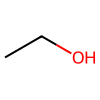

SMILES generated from the interface :  CCO
Structure 3D:

     RDKit          3D

  9  8  0  0  0  0  0  0  0  0999 V2000
   -0.9535    0.0478    0.0425 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.4891   -0.3204   -0.1886 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.2770    0.3248    0.7377 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.3570    0.7340   -0 ...
Energy : -0.002418 Hartree


In [7]:

from src.ThermoPred.reaction_utils import generate_3D, calculate_energy_with_rdkit
from rdkit import Chem
from rdkit.Chem import Draw

# Exemple of a smile as if the user had drawn
smiles = "CCO"  

# Molecule drawn by the user
mol = Chem.MolFromSmiles(smiles)
if mol:
    display(Draw.MolToImage(mol, size=(100, 100)))


print("SMILES generated from the interface : ", smiles)

# Structure 3D
molblock = generate_3D(smiles)
if molblock:
    print("Structure 3D:")
    print(molblock[:300], "...") 

# Energy calculated
energy, elements, coords = calculate_energy_with_rdkit(smiles)
print(f"Energy : {energy:.6f} Hartree")




## 2. Generating a Product 

Product generation is handled through a template-based reaction prediction system. A collection of common reaction templates were implemented in SMARTS format, including:

* Amide formation
* SN2 substitutions (halide with hydroxyl or amine)
* Carbon-carbon coupling reactions
* Interhalogen compound formation

The `react` function analyzes two input molecules and attempts to match them against these reaction templates. It works by:

* Converting SMILES strings to RDKit molecule objects
* Checking special cases (like elemental halogen reactions)
* Analyzing structural features to identify likely reaction types
* Testing applicable reaction templates systematically
* Returning the most probable product and template used

For reactions that potentially generate multiple products (indicated by dot-separated SMILES), we implemented the `get_main_product` function to identify and isolate the largest molecular component based on atom count.
The prediction system is flexible, allowing either automatic template detection or user-selected reaction pathways. When no suitable template is found, the system notifies the user that the reaction is unlikely to occur under standard conditions. Here's an example usage: 

In [5]:
import sys
import os
from pathlib import Path
from rdkit import Chem
from src import reaction_utils
rxn_utils= Path("C:/Users/Maria/Desktop/projectppchem/ThermoPred/src/ThermoPred/reaction_utils")
sys.path.append(str(rxn_utils))
from reaction_utils import (REACTION_TEMPLATES,get_main_product,react )
reactant1= "CCCCCl"
reactant2= "CBr"
product, template_used= react(reactant1, reactant2)
main_product= get_main_product(product) if product and "." in product else product
print (main_product)


ImportError: cannot import name 'reaction_utils' from 'src' (unknown location)

## 3. Calculation of the molecule's energy 

Furthermore, the energy of each molecule was required. To obtain that information the initial idea was to convert the drawn molecule into a xyz file in order to optimize its geometry and calculate the energy of the molecule. The latter process presented many difficulties:
Initially the geometry optimization was intended to be done using xTB package then, the geometry analysis to calculate the energy by morfeus. 
However, many issues were encountered with the use of the xTB package, segmentation problems were frequent despite many attempt to avoid it, such as trying different xTB calculus methods as backups. 
Thus, to still be able to calculate the energy of the molecules, it was chosen to give up part of the accuracy of the energy and use the rdkit package instead to avoid segmentation issues.
The function "calculate_energy_with_rdkit" which takes smiles as an entry used to calculate the energy of the various molecules involved in this project was designed with the following architecture:

In [ ]:
def calculate_energy_with_rdkit(smiles, optimize_steps=500):
    """Calculate a molecule's energy using RDKit instead of xTB"""
    try:
        # Clean the SMILES
        if "." in smiles:
            smiles = get_main_product(smiles)
        
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError(f"Cannot read SMILES: {smiles}")
        
        mol = Chem.AddHs(mol)
        
        # Generate a clean 3D molecule
        params = AllChem.ETKDGv3()
        params.useRandomCoords = True
        params.randomSeed = 42
        params.maxIterations = 1000  
        AllChem.EmbedMultipleConfs(mol, numConfs=10, params=params)

        #tests that there are indeed 3D version of the molecule to calculate the energy of
        if mol.GetNumConformers() == 0:
            raise ValueError("Failed to generate 3D coordinates")
        
        # All conformations are optimized to take the lowest energy later
        energies = []
        for conf_id in range(mol.GetNumConformers()):
            try:
                # Setting up the MMFF94 field
                mp = AllChem.MMFFGetMoleculeProperties(mol, mmffVariant='MMFF94s')
                if mp is None:
                    continue
                
                ff = AllChem.MMFFGetMoleculeForceField(mol, mp, confId=conf_id)
                if ff is None:
                    continue
                
                # Optimization
                ff.Initialize()
                result = ff.Minimize(maxIts=optimize_steps)
                
                # Energy calculation
                energy = ff.CalcEnergy()
                energies.append((conf_id, energy))
            except Exception as e:
                continue
        
        if not energies:
            # UFF method as backup
            for conf_id in range(mol.GetNumConformers()):
                try:
                    ff = AllChem.UFFGetMoleculeForceField(mol, confId=conf_id)
                    if ff is None:
                        continue
                    
                    ff.Initialize()
                    result = ff.Minimize(maxIts=optimize_steps)
                    energy = ff.CalcEnergy()
                    energies.append((conf_id, energy))
                except Exception as e:
                    continue
        #targeted error
        if not energies:
            raise ValueError("Cannot calculate energy with MMFF94 or UFF")
        
        # Take the lowest energy
        energies.sort(key=lambda x: x[1])
        best_conf_id, lowest_energy = energies[0]
        
        # Convert to Hartree
        energy_hartree = lowest_energy / 627.5  # 1 Hartree ≈ 627.5 kcal/mol
        
        # Create xyz data
        conf = mol.GetConformer(best_conf_id)
        elements = [atom.GetSymbol() for atom in mol.GetAtoms()]
        coordinates = np.array([list(conf.GetAtomPosition(i)) for i in range(mol.GetNumAtoms())])
        
        return energy_hartree, elements, coordinates
    
    except Exception as e:
        raise ValueError(f"Error calculating energy: {str(e)}")

Then, once the individual energy for each molecule was calculated, a comparison function ("Energy_comparison") was elaborated to compare the energy at the starting and ending point of the reaction and conclude on its spontaneous character. 
The energy of the reactant was added toghether, then a local variable associated to the difference in energy between the combined reactant and the product generated was evaluated. If the latter variable was negative the function returned the following bolean "True" that would latter be interpreated as a spontaneous reaction. Analogous in when the vaiable is positive. 

## 4. Results
The code was tested with several common reaction types to evaluate the quality of prediction. Here are selected examples demonstrating the systems performance....( A RAJOUTER)

These results demonstarte that the code can sucessfully: 
1. Identify appropriate reaction templates for different molecular structures
2. Generate chemically reasonable products
3. Calculate enegry differences that align with theoretical expectations

For cases where reaction template did not match the input molecules, the code correctly reported that no spontaneous reaction was expected.

The Streamlit interface provided an intuitive visualization of both the reaction participants and outcomes. USers could easely see:
* 3D models of both reactants and the predicted product
* Energy values for each molecule
* The calculated energy change (ΔE) in both Hartree and kcal/mol
* A clear indication of whether the reaction is thermodynamically favorable

## 5. Discussion

### Interface Usability
The Streamlit-based user interface provided an accessible way for users to interact with complex computational chemistry tools. However, several areas for improvement were identified:
1. The page "jump" to Molecule 2 disrupted the user experience. One way of solving it would have been to put the two interfaces for Molecule 1 and 2 next to each other, but then we would lose the sibebar for choosing specific atoms such as Br, O or S.
3. Additional visualization options (like electrostatic potential maps) would enhance understanding


### Accuracy of Template-Based Reaction Prediction
The template-based approach provided a straightforward way to predict reaction outcomes for common reaction types. However, this method has inherent limitations:
1. It can only predict reactions that match pre-defined templates
2. It does not account for kinetic factors that might prevent thermodynamically favorable reactions
3. Complex reactions involving multiple steps or rearrangements cannot be modeled

For the simple reactions tested, our system showed good agreement with expected chemical behavior. For example, amide formation from carboxylic acids and amines is known to be thermodynamically favorable, which our calculations confirmed.

### Energy Calculation Precision
Our decision to use RDKit force fields rather than quantum mechanical methods introduced a trade-off between computational efficiency and accuracy. While sufficient for relative comparisons, the absolute energy values should be interpreted with caution:
1. Force fields like MMFF94s are parameterized for common organic structures and may be less accurate for unusual chemical environments
2. The calculations do not explicitly account for solvation effects
3. Zero-point energy corrections are not included

### Technical Challenges
Several significant technical challenges were encountered during development:
1. __Segmentation issues with xTB__: Despite multiple attempts and alternative methods, we could not resolve these issues, leading to our adoption of RDKit
2. __Molecular representation conversions__: Maintaining consistency across different representations (SMILES, molblock, 3D coordinates) required careful implementation
3. __Exception handling__: Chemical calculations frequently encounter edge cases requiring robust error handling

### Conclusion
We successfully developed a computational system that predicts chemical reaction products and assesses their thermodynamic stability at 0K. Our approach combines:
1. An intuitive molecular drawing interface
2. Template-based reaction prediction
3. Force field-based energy calculations
4. Clear visualization of results
The system effectively demonstrates the concept of using free enthalpy calculations to predict reaction spontaneity, providing a valuable educational and exploratory tool for chemistry students and researchers.

### Future Improvements
Several enhancements could improve the system's capabilities:

1. Implementation of quantum mechanical methods for more accurate energy calculations
2. Expansion of the reaction template library to cover more reaction types
3. Addition of temperature effects to predict reaction favorability under different conditions
4. Integration of transition state modeling to address kinetic factors
5. Improvements to the user interface to address identified usability issues

This project demonstrates the potential of computational approaches to provide rapid insights into chemical reactivity, potentially reducing the need for experimental trial-and-error in reaction development.
